In [2]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')
pd.set_option('display.max_columns', None)

/var/folders/gw/xg9wcgln7x1f2k7qpz6vkm_c0000gn/T/ipykernel_30408/1522025319.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/varnika/Desktop/harvard/all_var_int.csv')


In [3]:
sensitivity_vars = [
    "sc_ratio", "st_ratio", "gen_ratio",
    "anaemic_pregnant_ratio", "anaemic_adolescent_ratio",
    "hh_kutcha_wall_roof",
    "pmuy_ratio",
    "hh_non_farm_ratio"]

In [5]:
import pandas as pd
import numpy as np


# Subset columns
id_cols = ["state_code", "district_code", "block_code", "FID_Key"]  # or whichever ID columns you want
landslide_sens_cols = id_cols + sensitivity_vars

# Create a new DataFrame
landslide_sens_df = df[landslide_sens_cols].copy()



In [6]:
from sklearn.preprocessing import RobustScaler

Rscaler = RobustScaler()

# Only scale the sensitivity variables, not the ID columns
features_only = landslide_sens_df[sensitivity_vars].values.astype(float)
features_scaled = Rscaler.fit_transform(features_only)

# Create scaled DataFrame
sens_scaled = pd.DataFrame(features_scaled, 
                           columns=sensitivity_vars, 
                           index=landslide_sens_df.index)

# Merge or keep separate
for col in sensitivity_vars:
    landslide_sens_df[col + "_scaled"] = sens_scaled[col]


In [7]:
from sklearn.decomposition import PCA

# Collect only the scaled columns for PCA
sens_pca_vars = [col for col in landslide_sens_df.columns if col.endswith("_scaled")]
X_sens = landslide_sens_df[sens_pca_vars].astype(float)

pca = PCA()
pca.fit(X_sens)

# Summarize variance
pcaSummary_sens = pd.DataFrame({
    '% variance': pca.explained_variance_ratio_,
    'Cumulative %': np.cumsum(pca.explained_variance_ratio_)
})
print(pcaSummary_sens.round(3))


   % variance  Cumulative %
0       0.500         0.500
1       0.162         0.662
2       0.091         0.754
3       0.064         0.818
4       0.062         0.880
5       0.051         0.930
6       0.039         0.970
7       0.030         1.000


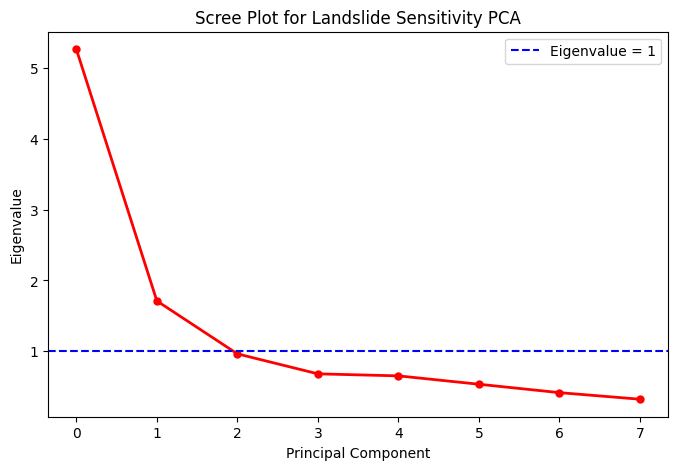

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Suppose you have your scaled data in X_sens (e.g., 'sensitivity_vars' scaled):
pca = PCA()  
pca.fit(X_sens)

# Eigenvalues (variances of each principal component)
eigenvalues = pca.explained_variance_

# Create x-axis values: one for each PC
xvals = np.arange(len(eigenvalues))  # e.g., [0, 1, 2, 3, ...]

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(xvals, eigenvalues, 'ro-', linewidth=2, markersize=5)
plt.title("Scree Plot for Landslide Sensitivity PCA")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")

# Often, a horizontal line at y=1 helps visualize how many PCs are above that “latent root” threshold
plt.axhline(y=1, color='b', linestyle='--', label="Eigenvalue = 1")

# Label x-ticks to match component indices
plt.xticks(xvals)

plt.legend()
plt.show()


In [10]:
loadings_sens = pd.DataFrame(
    pca_n.components_.T,  # transpose so rows=variables, cols=PCs
    index=X_sens.columns,
    columns=[f"PC{i+1}" for i in range(n_components)]
)
print(loadings_sens)


                                      PC1       PC2       PC3
sc_ratio_scaled                 -0.131277  0.023364 -0.028567
st_ratio_scaled                  0.936729  0.211581  0.184391
gen_ratio_scaled                -0.267133  0.083335  0.585005
anaemic_pregnant_ratio_scaled    0.091613 -0.556484  0.125998
anaemic_adolescent_ratio_scaled  0.113273 -0.699216  0.389754
hh_kutcha_wall_roof_scaled       0.073905 -0.202125 -0.411658
pmuy_ratio_scaled                0.037670 -0.186778 -0.208866
hh_non_farm_ratio_scaled        -0.076423  0.270971  0.492018


In [12]:
n_components = 2
pca_n = PCA(n_components=n_components)
X_sens_pca = pca_n.fit_transform(X_sens)

# Weights for each PC = explained variance ratio of those PCs
pca_weights = pcaSummary_sens['% variance'][:n_components]

# Add the chosen PC scores to the DataFrame
for i in range(n_components):
    landslide_sens_df[f"Sensitivity_PC{i+1}"] = X_sens_pca[:, i]

# Weighted sum => "Landslide_Sensitivity_Index"
landslide_sens_df["Landslide_Sensitivity_Index"] = 0
for i in range(n_components):
    landslide_sens_df["Landslide_Sensitivity_Index"] += (
        pca_weights.iloc[i] * landslide_sens_df[f"Sensitivity_PC{i+1}"]
    )

# Quick look
print(landslide_sens_df[["block_code", "Landslide_Sensitivity_Index"]].head())
print(landslide_sens_df["Landslide_Sensitivity_Index"].describe())


   block_code  Landslide_Sensitivity_Index
0        6498                    -0.197468
1        6492                    -0.477146
2        4689                    -0.363960
3        4690                    -0.140275
4        4692                    -0.389798
count    5.815000e+03
mean    -2.199444e-17
std      1.167030e+00
min     -3.098776e+00
25%     -5.048636e-01
50%     -3.977957e-01
75%      5.544876e-03
max      5.138059e+01
Name: Landslide_Sensitivity_Index, dtype: float64
